In [1]:
import condo
import numpy as np
import matplotlib.pyplot as plt
import ot
import pandas as pd
import seaborn as sns
import sklearn
import time
import warnings

from matplotlib.colors import LogNorm

In [2]:
N_T = 100
N_S = 100

# How confounder X affects the distribution of T and S
mu_hotdog = 5.
sigma_hotdog = 1.0
mu_not = 0.0
sigma_not = 2.0

# How batch effect affects S
batch_m = 2
batch_b = 5
# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

In [3]:
n_hotdogT = 75 
n_notT = 25
n_hotdogS = 25
n_notS = 75
X_T = np.array([['hotdog']*n_hotdogT + ['not']*n_notT]).reshape((N_T, 1))
X_S = np.array([['hotdog']*n_hotdogS + ['not']*n_notS]).reshape((N_S, 1))

In [4]:
Strue = np.nan * np.ones((N_S, 1))
T = np.nan * np.ones((N_T, 1))
Strue[np.where(X_S[:,0] == 'hotdog'), 0] = np.random.normal(
    mu_hotdog, sigma_hotdog, size=(n_hotdogS))
T[np.where(X_T[:,0] == 'hotdog'), 0] = np.random.normal(
    mu_hotdog, sigma_hotdog, size=(n_hotdogT))
Strue[np.where(X_S[:,0] == 'not'), 0] = np.random.normal(
    mu_not, sigma_not, size=(n_notS))
T[np.where(X_T[:,0] == 'not'), 0] = np.random.normal(
    mu_not, sigma_not, size=(n_notT))

Sbatch = batch_m * Strue + batch_b

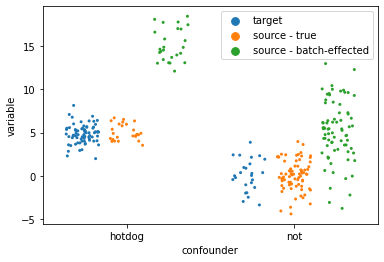

In [5]:
dfT = pd.concat([
    pd.DataFrame(T, columns=['variable']), pd.DataFrame(X_T, columns=['confounder'])
], axis=1)
dfT["batch"] = "target"
dfStrue = pd.concat([
    pd.DataFrame(Strue, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfStrue["batch"] = "source - true"
dfSbatch = pd.concat([
    pd.DataFrame(Sbatch, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSbatch["batch"] = "source - batch-effected"

df = pd.concat([dfT, dfStrue, dfSbatch], axis=0)
sns.stripplot(
    x="confounder",
    y="variable",
    hue="batch",
    jitter=0.3,
    dodge=True,
    s=3,
    data=df)
plt.legend(loc='best', title='');

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="affine",
        divergence="mmd",
        model_type="empirical",
        mmd_kwargs={"epochs": 50, "batch_size": 16, "alpha": 1e-2, "beta": 0.0},
        debug=False,
        verbose=1
    )
    cder.fit(Sbatch, T, X_S, X_T)
    Sadapted = cder.transform(Sbatch)
    
lter = ot.da.LinearTransport()
lter.fit(Xs=Sbatch, Xt=T)
Slinear = lter.transform(Xs=Sbatch)

epoch:0 -0.43440->-0.58283 avg:-0.44064
epoch:1 -0.48466->-0.57187 avg:-0.55886
epoch:2 -0.63289->-0.55156 avg:-0.55543
epoch:3 -0.54604->-0.58179 avg:-0.56022
epoch:4 -0.42832->-0.59086 avg:-0.56124
epoch:5 -0.49140->-0.58197 avg:-0.56540
epoch:6 -0.55538->-0.52607 avg:-0.56641
epoch:7 -0.57205->-0.48761 avg:-0.57552
epoch:8 -0.69913->-0.61005 avg:-0.57262
epoch:9 -0.58715->-0.53826 avg:-0.56225
epoch:10 -0.50234->-0.55047 avg:-0.56094
epoch:11 -0.60549->-0.57289 avg:-0.57486
epoch:12 -0.47805->-0.62046 avg:-0.57337
epoch:13 -0.51995->-0.51980 avg:-0.56899
epoch:14 -0.56980->-0.56740 avg:-0.58870
epoch:15 -0.61688->-0.61611 avg:-0.56856
epoch:16 -0.56030->-0.57467 avg:-0.58753
epoch:17 -0.60565->-0.50471 avg:-0.57403
epoch:18 -0.63275->-0.54769 avg:-0.58335
epoch:19 -0.59259->-0.58730 avg:-0.58708
epoch:20 -0.48263->-0.51177 avg:-0.58357
epoch:21 -0.63114->-0.51138 avg:-0.58052
epoch:22 -0.60193->-0.59606 avg:-0.57457
epoch:23 -0.54682->-0.63769 avg:-0.59551
epoch:24 -0.63904->-0.5585

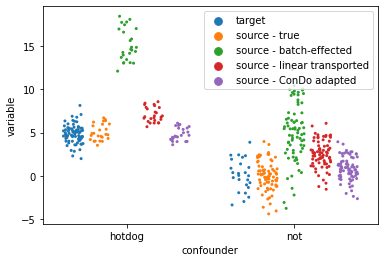

In [8]:
dfSadapted = pd.concat([
    pd.DataFrame(Sadapted, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSadapted["batch"] = "source - ConDo adapted"

dfSlinear = pd.concat([
    pd.DataFrame(Slinear, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSlinear["batch"] = "source - linear transported"

df = pd.concat([dfT, dfStrue, dfSbatch, dfSlinear, dfSadapted], axis=0)
sns.stripplot(
    x="confounder",
    y="variable",
    hue="batch",
    jitter=0.3,
    dodge=True,
    s=3,
    data=df)
plt.legend(loc='best', title='');

In [ ]:
print(batch_m, batch_b)
print(true_m, true_b)
print(cder.M_, cder.b_)
print((lter.A_, lter.B_))

In [ ]:
print(np.sqrt(np.mean((Strue - Slinear) ** 2)))
print(np.sqrt(np.mean((Strue - Sadapted) ** 2)))

In [ ]:
plt.figure(figsize=(5,4), dpi=150)
color_vals = cder.mb_objs_ + 1 - np.min(cder.mb_objs_)
plt.pcolormesh(
    cder.m_plot_, cder.b_plot_, color_vals.T,
    norm=LogNorm(vmin=color_vals.min(), vmax=color_vals.max()));
"""
plt.xscale('log');

cbar = plt.colorbar();
cbar.ax.get_yaxis().set_ticks([color_vals.min(), color_vals.max()]);
cbar.ax.get_yaxis().set_ticklabels(
    [int(np.round(cder.mb_objs_.min())), int(np.round(cder.mb_objs_.max()))]);
cont = plt.contour(
    cder.m_plot_, cder.b_plot_, color_vals.T, 
    levels=np.geomspace(color_vals.min(), color_vals.max(), 8), colors='white', linestyles='solid');
plt.ylabel('b');
plt.xlabel('m');
plt.scatter(true_m, true_b, marker='s', c='orange');
plt.scatter(cder.m_, cder.b_, marker='x', c='red');
plt.tight_layout();
"""

In [ ]:
vars(cder)

In [ ]:
cder.m_plot_